In [ ]:
# default_exp models

## models

In [ ]:
#hide
from torchtools.core import *

In [ ]:
#export
import torch.nn as nn
import torch as torch
import torch.nn.functional as F

from functools import partial

In [ ]:
torch.__version__

'1.3.1'

In [ ]:
torch.sigmoid(torch.tensor([-2.])) * (1 - -1) + -1

tensor([-0.7616])

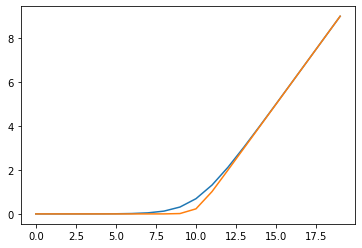

In [ ]:
import matplotlib.pyplot as plt
t = torch.arange(-10,10).float()
# plt.plot(t)
plt.plot(F.softplus(t, beta=1))
plt.plot(F.softplus(t, beta=3))

In [ ]:
#export
# This is an unofficial PyTorch implementation by Ignacio Oguiza - oguiza@gmail.com based on:

# Fawaz, H. I., Lucas, B., Forestier, G., Pelletier, C., Schmidt, D. F., Weber, J., ... & Petitjean, F. (2019). InceptionTime: Finding AlexNet for Time Series Classification. arXiv preprint arXiv:1909.04939.
# Official InceptionTime tensorflow implementation: https://github.com/hfawaz/InceptionTime


def noop(x):
    return x

def shortcut(c_in, c_out):
    return nn.Sequential(*[nn.Conv1d(c_in, c_out, kernel_size=1), 
                           nn.BatchNorm1d(c_out)])
    
class Inception(nn.Module):
    def __init__(self, c_in, bottleneck=32, ks=40, nb_filters=32):

        super().__init__()
        self.bottleneck = nn.Conv1d(c_in, bottleneck, 1) if bottleneck and c_in > 1 else noop
        mts_feat = bottleneck or c_in
        conv_layers = []
        kss = [ks // (2**i) for i in range(3)]
        # ensure odd kss until nn.Conv1d with padding='same' is available in pytorch 1.3
        kss = [ksi if ksi % 2 != 0 else ksi - 1 for ksi in kss]  
        for i in range(len(kss)):
            conv_layers.append(
                nn.Conv1d(mts_feat, nb_filters, kernel_size=kss[i], padding=kss[i] // 2))
        self.conv_layers = nn.ModuleList(conv_layers)
        self.maxpool = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv = nn.Conv1d(c_in, nb_filters, kernel_size=1)
        self.bn = nn.BatchNorm1d(nb_filters * 4)
        self.act = nn.ReLU()

    def forward(self, x):
        input_tensor = x.to(torch.float)
        x = self.bottleneck(input_tensor)
        for i in range(3):
            out_ = self.conv_layers[i](x)
            if i == 0: out = out_
            else: out = torch.cat((out, out_), 1)
        mp = self.conv(self.maxpool(input_tensor))
        inc_out = torch.cat((out, mp), 1)
        return self.act(self.bn(inc_out))


class InceptionBlock(nn.Module):
    def __init__(self,c_in,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):

        super().__init__()

        self.residual = residual
        self.depth = depth

        #inception & residual layers
        inc_mods = []
        res_layers = []
        res = 0
        for d in range(depth):
            inc_mods.append(
                Inception(c_in if d == 0 else nb_filters * 4, bottleneck=bottleneck if d > 0 else 0,ks=ks,
                          nb_filters=nb_filters))
            if self.residual and d % 3 == 2:
                res_layers.append(shortcut(c_in if res == 0 else nb_filters * 4, nb_filters * 4))
                res += 1
            else: res_layer = res_layers.append(None)
        self.inc_mods = nn.ModuleList(inc_mods)
        self.res_layers = nn.ModuleList(res_layers)
        self.act = nn.ReLU()
        
    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inc_mods[d](x)
            if self.residual and d % 3 == 2:
                res = self.res_layers[d](res)
                x += res
                res = x
                x = self.act(x)
        return x

In [ ]:
#export    
class InceptionTime(nn.Module):
    def __init__(self,c_in,c_out,bottleneck=32,ks=40,nb_filters=32,residual=True,depth=6):
        super().__init__()
        self.block = InceptionBlock(c_in,bottleneck=bottleneck,ks=ks,nb_filters=nb_filters,
                                    residual=residual,depth=depth)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nb_filters * 4, c_out)

    def forward(self, x):
        x = self.block(x)
        x = self.gap(x).squeeze(-1)
        x = self.fc(x)
        return x

In [ ]:
#export
class Sigmoid(nn.Module):
    '''
    sigmoid layer
    '''
    def __init__(self, low, high):
        super().__init__()
        self.high, self.low = high, low
        
    def forward(self, x):
        return torch.sigmoid(x)*(self.high-self.low)+self.low

In [ ]:
#export
class InceptionTimeSgmOld(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out):
        super().__init__()
        nn.Sequential()
        self.inc = InceptionTime(n_in, n_out)
        self.low, self.high = -1., 1.
        
    def forward(self, x):
        return torch.sigmoid(self.inc(x)) * (self.high - self.low) + self.low
        

In [ ]:
#export
class InceptionTimeSgm(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out, range=(-1,1)):
        super().__init__()
        self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(*range))
        
    def forward(self, x):
        x = x.float()
        return self.mod(x)
        

In [ ]:
#export
class InceptionTimeD(nn.Module):
    '''
    add a sigmoid layer to InceptionTime to get the ouput in a certain range
    '''
    
    def __init__(self, n_in, n_out):
        super().__init__()
        self.mod = nn.Sequential(InceptionTime(n_in, n_out), Sigmoid(-1., 1.))
        
    def forward(self, xc, xd):
        x = torch.cat([xc.float(), xd.float()], dim=-2)
        x = x.float()
#         print(f'InceptionTimeSgm dtype {x.dtype}')
        return self.mod(x)

### Development

In [ ]:
#export
class InceptionTimeVar(nn.Module):
    '''
    output mean and variance
    regression model, sigmoid for the mean output optional
    '''
    
    def __init__(self, n_in, n_out, meanrange=None):
        super().__init__()
        models  = [InceptionTime(n_in, n_out+1)]
        if meanrange:
            self.sigmoid = Sigmoid(*meanrange)
        self.mod = nn.Sequential(*models)
        
    def forward(self, x):
        x = x.float()
        output = self.mod(x)
        ## enforce positivity of sigma^2
        ##output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
#         output[:,-1] = (output[:,-1].exp()+1).log_() + 1e-06
        output[:,-1] = F.softplus(output[:,-1])
        
        if getattr(self, 'sigmoid', None): output[:,:-1] = self.sigmoid(output[:,:-1])
        return output
        

In [ ]:
# model sanity checks
xb = torch.randn((128,10,100))
yb = torch.rand(128,1)
model = InceptionTimeVar(10,1)

preds = model(xb)
assert preds.shape == (128,2)

In [ ]:
#export
def nll_regression(preds, y_true, c=5):
    '''
    negative log likelihood loss for regression, both mu and sigma are predicted
    
    Simple and Scalable Predictive UncertaintyEstimation using Deep Ensembles
    Balaji Lakshminarayanan, Alexander Pritzel, Charles Blundell, DeepMind

    '''
    
    s1 = 0.5*preds[:,1].log() 
    s2 = 0.5*(yb.squeeze()-preds[:,0]).pow(2).div(preds[:,1])
    loss = (s1+s2).mean() + c
    return loss

In [ ]:
#export
def nll_leaky_loss(preds, y_true, c=5, alpha=0.5):
    '''
    leaky_loss with variance
    
    Simple and Scalable Predictive UncertaintyEstimation using Deep Ensembles
    Balaji Lakshminarayanan, Alexander Pritzel, Charles Blundell, DeepMind

    '''
    
    s1 = 0.5*preds[:,1].log() 
    l1 = -F.leaky_relu(preds[:,0], alpha)*y_true.float().squeeze()
    s2 = 0.5*(l1.div(preds[:,1]+1)) ## +1 to prevent optimizing for variance, maybe just an artifical problem
    loss = (s1+s2).mean() + c
    return loss

In [ ]:
loss = nll_leaky_loss(preds, yb)

print(loss)

tensor(4.7944, grad_fn=<AddBackward0>)


In [ ]:
model_var = InceptionTimeVar(10,1,meanrange=(-1,1))

In [ ]:
#simple training loop

lr = 0.01
epochs = 10
loss_fn = nll_regression
m = model_var
loss_fn = nll_leaky_loss


for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    loss.backward()
    with torch.no_grad():
        for p in m.parameters():
            p.sub_(lr*p.grad)
    m.zero_grad()

tensor(4.7193, grad_fn=<AddBackward0>)
tensor(4.6247, grad_fn=<AddBackward0>)
tensor(4.5210, grad_fn=<AddBackward0>)
tensor(4.4083, grad_fn=<AddBackward0>)
tensor(4.2872, grad_fn=<AddBackward0>)
tensor(4.1583, grad_fn=<AddBackward0>)
tensor(4.0228, grad_fn=<AddBackward0>)
tensor(3.8817, grad_fn=<AddBackward0>)
tensor(3.7362, grad_fn=<AddBackward0>)
tensor(3.5873, grad_fn=<AddBackward0>)


In [ ]:
unweighted_profit(m(xb)[:,0], yb)

tensor(0.4946)

In [ ]:
model_var = InceptionTimeVar(10,1)
opt = torch.optim.Adam(model_var.parameters(), lr=0.001)

In [ ]:
m = model_var
for i in range(epochs):
    preds = m(xb)
    loss = nll_regression(preds, yb)
    print(loss)
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(5.4290, grad_fn=<AddBackward0>)
tensor(5.0269, grad_fn=<AddBackward0>)
tensor(4.8126, grad_fn=<AddBackward0>)
tensor(4.6762, grad_fn=<AddBackward0>)
tensor(4.5883, grad_fn=<AddBackward0>)
tensor(4.5294, grad_fn=<AddBackward0>)
tensor(4.4923, grad_fn=<AddBackward0>)
tensor(4.4652, grad_fn=<AddBackward0>)
tensor(4.4323, grad_fn=<AddBackward0>)
tensor(4.3830, grad_fn=<AddBackward0>)


In [ ]:
model_var = InceptionTimeVar(10,1,meanrange=(-10,5))
m = model_var
loss_fn = partial(nll_leaky_loss, alpha=0.5)
epochs=10

opt = torch.optim.Adam(m.parameters(), lr=1e-4)

for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(5.1520, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.1394, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.1270, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.1148, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.1026, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.0905, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.0783, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.0660, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.0535, grad_fn=<AddBackward0>)
tensor(0.)
tensor(5.0408, grad_fn=<AddBackward0>)
tensor(0.)


In [ ]:
unweighted_profit(m(xb)[:,0],yb)

tensor(0.)

In [ ]:
import numpy as np

In [ ]:
np.round(m(xb).detach().numpy(), 2)

array([[-2.17,  0.8 ],
       [-1.8 ,  0.75],
       [-3.86,  0.76],
       [-3.1 ,  0.73],
       [-2.33,  0.75],
       [-3.93,  0.74],
       [-2.93,  0.75],
       [-2.35,  0.72],
       [-3.42,  0.78],
       [-3.2 ,  0.74],
       [-1.83,  0.83],
       [-3.06,  0.71],
       [-3.48,  0.8 ],
       [-4.16,  0.73],
       [-3.68,  0.76],
       [-3.1 ,  0.69],
       [-1.5 ,  0.76],
       [-1.45,  0.79],
       [-5.18,  0.68],
       [-2.34,  0.76],
       [-4.19,  0.66],
       [-4.51,  0.66],
       [-2.35,  0.8 ],
       [-2.4 ,  0.82],
       [-2.24,  0.73],
       [-3.72,  0.72],
       [-3.03,  0.74],
       [-3.01,  0.72],
       [-2.87,  0.77],
       [-4.23,  0.71],
       [-2.57,  0.83],
       [-3.53,  0.7 ],
       [-3.51,  0.74],
       [-2.64,  0.68],
       [-2.39,  0.78],
       [-2.61,  0.76],
       [-1.85,  0.77],
       [-2.53,  0.76],
       [-1.52,  0.74],
       [-2.99,  0.74],
       [-4.16,  0.75],
       [-2.63,  0.7 ],
       [-3.39,  0.71],
       [-1.

In [ ]:
x1 = torch.zeros(128,1)
x2 = torch.ones(128,1)

In [ ]:
x_p = torch.cat([x1,x2], dim=1)

In [ ]:
nll_regression(x_p, yb)

tensor(5.1679)

In [ ]:
t=torch.randn(100)
torch.sigmoid(t)*(1.3-0.9)+0.9


tensor([1.1095, 1.1603, 1.1815, 1.1474, 1.1794, 1.2441, 1.1129, 1.1118, 1.1436,
        1.0182, 1.0465, 0.9802, 1.2020, 1.0536, 1.2171, 1.0186, 0.9801, 1.0531,
        0.9563, 1.1134, 0.9458, 0.9907, 1.2233, 1.0600, 1.1663, 1.0706, 1.1901,
        1.1641, 1.0343, 1.1157, 1.0153, 0.9864, 1.1957, 1.1244, 1.0309, 1.0621,
        1.0693, 0.9547, 1.0510, 1.2013, 1.1592, 1.1030, 1.1770, 1.1139, 1.1817,
        1.0980, 0.9601, 1.1749, 1.1532, 1.2252, 1.0789, 1.1025, 1.0111, 1.1277,
        1.0475, 1.0164, 1.2084, 0.9721, 1.0259, 1.0407, 1.1503, 1.1958, 1.1083,
        1.1249, 1.2411, 0.9974, 0.9957, 1.0811, 1.0228, 0.9572, 1.0547, 1.0277,
        0.9785, 1.2495, 0.9694, 1.0753, 1.2210, 1.1757, 1.1876, 1.0128, 0.9789,
        1.2055, 1.0980, 1.0387, 1.0779, 1.0374, 0.9951, 1.1748, 1.1349, 0.9995,
        1.0444, 1.1635, 1.2683, 1.0247, 1.0698, 1.0439, 1.1007, 1.1141, 1.1531,
        1.0812])

In [ ]:
torch.sigmoid(t)

tensor([0.5913, 0.7275, 0.6183, 0.5189, 0.6616, 0.6775, 0.7000, 0.7109, 0.5841,
        0.6315, 0.7232, 0.5411, 0.6829, 0.7191, 0.5508, 0.5162, 0.7131, 0.7207,
        0.5158, 0.7128, 0.6950, 0.5704, 0.6903, 0.7302, 0.5538, 0.5747, 0.6909,
        0.6565, 0.6839, 0.5790, 0.7144, 0.6901, 0.7021, 0.5765, 0.6108, 0.6747,
        0.7227, 0.7173, 0.7185, 0.5146, 0.6119, 0.7285, 0.6731, 0.7155, 0.5086,
        0.6942, 0.6788, 0.5290, 0.5611, 0.7158, 0.6941, 0.6132, 0.6277, 0.6278,
        0.6790, 0.6894, 0.5219, 0.5740, 0.7114, 0.7063, 0.6639, 0.5869, 0.6681,
        0.6533, 0.6566, 0.6462, 0.6430, 0.7135, 0.6631, 0.5016, 0.6098, 0.6257,
        0.7183, 0.7010, 0.7022, 0.6265, 0.6993, 0.7100, 0.6913, 0.5921, 0.6228,
        0.7095, 0.5008, 0.6969, 0.5941, 0.5423, 0.7106, 0.6369, 0.6663, 0.6127,
        0.6994, 0.5936, 0.6483, 0.5113, 0.5580, 0.5715, 0.5325, 0.6815, 0.6862,
        0.6572])

In [ ]:
F.sigmoid()

In [ ]:
torch.ra

In [ ]:
def _create_random_results(size):
    high, low = 1.2, 0.9
    res=torch.randn(size)
    res = torch.sigmoid(res)*(high-low)+low
    res *= -100
    res[torch.rand(size)>0.5] = 100.
    return res

In [ ]:
yb = _create_random_results((128,1))

In [ ]:
nll_leaky_loss(preds, yb)

tensor(38.1166, grad_fn=<AddBackward0>)

In [ ]:
yb.mean()

tensor(-7.1893)

In [ ]:
model_var = InceptionTimeVar(10,1,meanrange=(-1,1))
m = model_var
loss_fn = partial(nll_leaky_loss, alpha=0.5)
epochs=20

opt = torch.optim.Adam(m.parameters(), lr=1e-4)

In [ ]:
for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(-5.8582, grad_fn=<AddBackward0>)
tensor(-3.5385)
tensor(-6.6025, grad_fn=<AddBackward0>)
tensor(-3.4823)
tensor(-7.3244, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-8.0178, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-8.6825, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-9.3129, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-9.9017, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-10.4434, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-10.9383, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-11.3915, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-11.8113, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-12.2062, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-12.5798, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-12.9334, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-13.2676, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-13.5844, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-13.8866, grad_fn=<AddBackward0>)
tensor(-3.4261)
tensor(-14.1788, grad_fn=<AddBackward0

In [ ]:
for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds[:,0], yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(-9317.9912, grad_fn=<AddBackward0>)
tensor(-3.7070)
tensor(-30340.9004, grad_fn=<AddBackward0>)
tensor(-3.7070)
tensor(-90235.2656, grad_fn=<AddBackward0>)
tensor(-3.8755)
tensor(-214640.3750, grad_fn=<AddBackward0>)
tensor(-3.9878)
tensor(-359202.5312, grad_fn=<AddBackward0>)
tensor(-4.0440)
tensor(-397443.5000, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444806.8125, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444799.9375, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444794.8438, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444791.0625, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444788.1875, grad_fn=<AddBackward0>)
tensor(-4.1001)
tensor(-444786., grad_fn=<AddBackward0>)
tensor(-4.1563)
tensor(-444784.2500, grad_fn=<AddBackward0>)
tensor(-4.1563)
tensor(-444782.7812, grad_fn=<AddBackward0>)
tensor(-4.3248)
tensor(-444781.6250, grad_fn=<AddBackward0>)
tensor(-4.3248)
tensor(-444780.6250, grad_fn=<AddBackward0>)
tensor(-4.4933)
tensor(-444779.7500, grad_fn=<Ad

In [ ]:
m(xb)

tensor([[ 0.8102,  0.3178],
        [-0.5239,  0.6837],
        [ 0.7969,  0.3428],
        [ 0.8238,  0.3040],
        [-0.6941,  0.6855],
        [-0.5750,  0.6674],
        [ 0.8599,  0.2828],
        [-0.6396,  0.6581],
        [-0.6178,  0.6803],
        [-0.6704,  0.7044],
        [ 0.7746,  0.3350],
        [-0.4117,  0.6518],
        [ 0.7976,  0.3109],
        [-0.6089,  0.6810],
        [ 0.7839,  0.3432],
        [ 0.8260,  0.3253],
        [-0.6338,  0.7247],
        [ 0.8098,  0.2983],
        [-0.7259,  0.6800],
        [ 0.7886,  0.3059],
        [-0.4271,  0.6483],
        [ 0.8405,  0.2760],
        [ 0.8067,  0.3065],
        [ 0.7801,  0.3093],
        [-0.6602,  0.6911],
        [ 0.7929,  0.3536],
        [ 0.7634,  0.3492],
        [-0.7213,  0.6978],
        [-0.6269,  0.7063],
        [ 0.7730,  0.3216],
        [ 0.8197,  0.2993],
        [ 0.8387,  0.2986],
        [ 0.8390,  0.2937],
        [ 0.7963,  0.3075],
        [-0.6434,  0.7037],
        [-0.5897,  0

In [ ]:
model_mean = InceptionTimeSgm(10,1, range=(-1,1))
m = model_mean
loss_fn = partial(leaky_loss, alpha=0.1)
# loss_fn = F.mse_loss

epochs=20

opt = torch.optim.Adam(m.parameters(), lr=1e-3)

for i in range(epochs):
    preds = m(xb)
    loss = loss_fn(preds, yb)
    print(loss)
    print(unweighted_profit(preds, yb))
    loss.backward()
    with torch.no_grad():
        opt.step()
        opt.zero_grad()
        

tensor(-0.1196, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.1918, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.2503, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.3002, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.3442, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.3833, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.4182, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.4494, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.4771, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5019, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5238, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5433, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5605, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5757, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.5891, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.6010, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.6116, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.6209, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.6293, grad_fn=<MulBackward0>)
tensor(0.)
tensor(-0.6368, grad_fn=<MulBac

In [ ]:
np.round(preds.detach().numpy(),2)

array([[ 59.69],
       [-44.33],
       [ 32.03],
       [ 48.34],
       [-71.35],
       [-90.21],
       [ 31.71],
       [-74.66],
       [-63.18],
       [-85.05],
       [ 27.3 ],
       [-40.44],
       [ 22.68],
       [-72.75],
       [ 16.64],
       [ 59.72],
       [-79.17],
       [ 51.5 ],
       [-74.85],
       [ 15.23],
       [-46.47],
       [ 54.3 ],
       [ 39.65],
       [ 40.41],
       [-78.55],
       [ 23.05],
       [ 19.68],
       [-73.84],
       [-63.5 ],
       [ 15.34],
       [ 32.78],
       [ 43.81],
       [ 47.92],
       [ 21.04],
       [-72.07],
       [-62.32],
       [ 55.13],
       [-50.59],
       [-22.92],
       [ 25.04],
       [-52.25],
       [ 58.79],
       [-80.96],
       [-63.03],
       [ 45.97],
       [-51.07],
       [-44.96],
       [ 36.12],
       [ 38.38],
       [-35.93],
       [ 48.57],
       [-81.71],
       [-75.16],
       [-14.51],
       [ 18.78],
       [ 45.45],
       [ 64.61],
       [ 21.41],
       [-47.83

In [ ]:
weighted_profit(preds, yb, threshold=70)

tensor(-8.0606, grad_fn=<MeanBackward0>)

In [ ]:
s1 = 0.5*preds[:,1].log() 

In [ ]:
s1.mean()

tensor(-0.4077, grad_fn=<MeanBackward0>)

In [ ]:
l1 = F.leaky_relu(preds[:,0], 0.5)*yb.float().squeeze()

In [ ]:
l1.mean()

tensor(50.2426, grad_fn=<MeanBackward0>)

In [ ]:
unweighted_profit(preds[:,0], yb)

tensor(-4.0440)

In [ ]:
F.leaky_relu(preds[:,0], 0.01)

tensor([ 8.1925e-01,  2.2035e-01,  7.7802e-01,  7.5209e-01, -9.6370e-03,
        -5.4069e-03,  8.3000e-01, -5.6366e-03, -9.5591e-03,  1.5291e-02,
         8.0178e-01,  1.9101e-01,  6.7007e-01, -9.8845e-03,  5.9902e-01,
         7.5299e-01, -1.4802e-03,  7.7943e-01, -9.4004e-03,  7.8837e-01,
        -4.1210e-03,  7.9112e-01,  7.8203e-01,  7.0024e-01, -1.0000e-02,
         7.9763e-01,  7.3333e-01, -4.8869e-03, -6.0198e-03,  5.9659e-01,
         6.4868e-01,  8.3074e-01,  8.6674e-01,  8.1339e-01, -8.5559e-03,
        -8.0417e-03,  8.7010e-01, -7.2772e-03,  2.4229e-01,  6.5914e-01,
        -9.9913e-03,  8.0144e-01, -6.2689e-03, -5.1532e-03,  8.4950e-01,
        -7.8629e-04, -5.0912e-03,  8.3450e-01,  6.9821e-01, -6.6265e-03,
         8.4684e-01, -1.4540e-03, -1.1866e-03, -5.2012e-04,  6.9449e-01,
         8.3494e-01,  7.6754e-01,  8.4125e-01, -7.3983e-03,  8.4954e-01,
         6.6644e-01, -7.9540e-03, -9.4522e-03,  7.9308e-01,  5.6524e-01,
        -4.2100e-03,  4.8191e-01,  8.4140e-01,  8.2

In [ ]:
l1

tensor([ 81.9255, -22.0001,  77.8021,  75.2093,  52.1226,  25.8011,  82.9995,
         28.4714,  48.0399,  -1.5908,  80.1777, -19.7501,  67.0073,  55.0419,
         59.9020,  75.2989,   7.4788,  77.9432,  54.3332,  78.8372,  20.9156,
         79.1120,  78.2034,  70.0237,  56.1900,  79.7627,  73.3333,  27.1952,
         33.1130,  59.6591,  64.8677,  83.0743,  86.6744,  81.3389,  45.9245,
         42.3194,  87.0103,  41.0345, -25.5582,  65.9136,  55.6011,  80.1443,
         29.4647,  28.9230,  84.9501,   3.7070,  26.5617,  83.4499,  69.8207,
         33.9378,  84.6835,   7.3470,   5.6708,   2.5431,  69.4486,  83.4943,
         76.7540,  84.1252,  37.5089,  84.9543,  66.6443,  41.6723,  44.7566,
         79.3078,  56.5244,  21.7490,  48.1913,  84.1402,  82.4076,  84.7987,
         70.9222,  15.2145,  51.2575,   1.5143,   7.5915,  38.2872,  69.5466,
         15.8526,  60.6424,  48.2346,  86.2634,  89.3767,  -7.8546,  84.9656,
         85.3088,   7.4551,  -8.3118,  74.5987,  50.2686,  32.92

In [ ]:
s2 = 0.5*(l1.div(preds[:,1]))

In [ ]:
np.round(s2.detach().numpy(), 0)

array([ 5.300000e+01, -8.000000e+00,  9.100000e+01,  4.700000e+01,
        5.150000e+02,  2.200000e+01,  4.500000e+01,  2.800000e+01,
        3.400000e+02, -1.000000e+00,  9.500000e+01, -7.000000e+00,
        4.400000e+01,  1.124000e+03,  5.500000e+01,  3.700000e+01,
        3.000000e+00,  4.100000e+01,  3.570000e+02,  9.000000e+01,
        1.500000e+01,  8.000000e+01,  1.010000e+02,  9.400000e+01,
        3.717994e+06,  5.000000e+01,  4.800000e+01,  3.100000e+01,
        3.200000e+01,  4.700000e+01,  4.500000e+01,  4.100000e+01,
        4.600000e+01,  7.500000e+01,  1.430000e+02,  7.400000e+01,
        6.100000e+01,  4.700000e+01, -6.000000e+00,  5.600000e+01,
        1.050800e+04,  6.000000e+01,  5.800000e+01,  2.400000e+01,
        4.300000e+01,  2.000000e+00,  2.100000e+01,  5.900000e+01,
        4.300000e+01,  4.900000e+01,  4.000000e+01,  3.000000e+00,
        3.000000e+00,  1.000000e+00,  4.100000e+01,  4.700000e+01,
        4.800000e+01,  1.710000e+02,  5.800000e+01,  7.900000e

In [ ]:
    loss = (s1+s2).mean() + c

In [ ]:
lr = 0.01
with torch.no_grad():
    for p in model_v.parameters():
        p -= p.grad * lr

In [ ]:
preds_2 = model_v(xb)

In [ ]:
loss_2 = nll_regression(preds_2, yb)

In [ ]:
loss_2

tensor(6.6749, grad_fn=<AddBackward0>)

In [ ]:
(0.5*preds[:,1].log() + 0.5*(yb.squeeze()-preds[:,0]).pow(2).div(preds[:,1].pow(2))).mean() + 5

tensor(9.1327, grad_fn=<AddBackward0>)

In [ ]:
p = list(model.parameters())[1]

In [ ]:
p.grad

### QD loss

High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach

In [ ]:
y_results = _create_random_results(10)

In [ ]:
y_results

tensor([ 100.0000,  100.0000, -105.5246,  100.0000,  100.0000, -103.9725,
        -109.0025, -103.6679,  100.0000, -109.7297])

In [ ]:
preds = torch.randn(10)

In [ ]:
y_lower=preds

In [ ]:
y_upper = preds + torch.rand(10)

In [ ]:
y_lower, y_upper, y_toy

(tensor([ 0.5228,  0.6698, -1.3370, -1.4433,  1.6161, -1.7076,  1.1021,  0.2209,
         -0.4566,  0.1096]),
 tensor([ 1.4219,  1.4838, -0.6285, -0.9521,  2.0129, -1.4467,  1.1511,  0.5733,
          0.2181,  0.3509]),
 tensor([-0.4609,  1.7691, -0.4418, -0.9305,  1.5658, -0.4735, -0.2524, -0.1192,
          1.4725,  0.7472]))

In [ ]:
#hard
y_toy = torch.randn(10)

In [ ]:
khu = (torch.sign(y_upper-y_toy) > 0).int()

In [ ]:
khl = (torch.sign(y_toy-y_lower) > 0).int()

In [ ]:
khl

tensor([0, 0, 1, 1, 0, 1, 0, 1, 0, 1], dtype=torch.int32)

In [ ]:
khu

tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0], dtype=torch.int32)

In [ ]:
##soft
s = 10
ksu = torch.sigmoid((y_upper-y_toy)*s)
ksl = torch.sigmoid((y_toy-y_lower)*s)


In [ ]:
np.round(ksu.numpy(),4)

array([1.    , 1.    , 0.    , 0.    , 1.    , 0.    , 0.9997, 0.9653,
       0.9992, 0.005 ], dtype=float32)

In [ ]:
np.round(ksl.numpy(), 3)

array([0.   , 0.   , 1.   , 1.   , 0.   , 1.   , 0.   , 0.55 , 0.393,
       1.   ], dtype=float32)

In [ ]:
##soft
s = 10
ksu = torch.sigmoid((y_upper-y_results)*s)
ksl = torch.sigmoid((y_results-y_lower)*s)

In [ ]:
ksu

tensor([0., 0., 1., 0., 0., 1., 1., 1., 0., 1.])

In [ ]:
ksl

tensor([1., 1., 0., 1., 1., 0., 0., 0., 1., 0.])

In [ ]:
y_results

tensor([ 100.0000,  100.0000, -105.5246,  100.0000,  100.0000, -103.9725,
        -109.0025, -103.6679,  100.0000, -109.7297])

In [ ]:
y_upper

tensor([ 1.4219,  1.4838, -0.6285, -0.9521,  2.0129, -1.4467,  1.1511,  0.5733,
         0.2181,  0.3509])

In [ ]:
torch.sigmoid(y_upper*y_results*0.01)

tensor([0.8056, 0.8152, 0.6600, 0.2785, 0.8821, 0.8182, 0.2219, 0.3556, 0.5543,
        0.4049])

Betting adaption

Given results targets `y_results`

In [ ]:
y_results

tensor([ 100.0000,  100.0000, -105.5246,  100.0000,  100.0000, -103.9725,
        -109.0025, -103.6679,  100.0000, -109.7297])

the NN predicts upper and lower bounds `y_upper`, `y_lower`

In [ ]:
y_upper, y_lower

(tensor([ 1.4219,  1.4838, -0.6285, -0.9521,  2.0129, -1.4467,  1.1511,  0.5733,
          0.2181,  0.3509]),
 tensor([ 0.5228,  0.6698, -1.3370, -1.4433,  1.6161, -1.7076,  1.1021,  0.2209,
         -0.4566,  0.1096]))

Similarly to leaky loss, we want both bounds to have the same sign as the target `y_results` and higher absolute values for more confidence

In [ ]:
#export
def qd_loss(preds, y_true, alpha=0.4, l=0.01, s=0.01, add=False):
    '''
    qd loss implementation adapted for "leaky loss problems"
    preds: predictions for both lower and upper bounds
    alpha: confidence intervall parameter, different from alpha in leaky_loss
    s: smoothing factor for sigmoid
    l: agrangian controlling width vs coverage (default in the paper impl. is 0.01 which seems lowI)
    '''
    if not add:
        y_lower, y_upper = preds[:, 0].clone(), preds[:, 1].clone()
    else:
        y_lower, y_upper = preds[:, 0].clone(), preds[:,0]+preds[:, 1]
    # hard counts, how many of the predictions have the right sign?
    khu = (torch.sign(y_upper*y_true) > 0).int()
    khl = (torch.sign(y_lower*y_true) > 0).int()
    # soft counts, sign step function replaced by a smoother sigmoid
    ksu = torch.sigmoid((y_upper*y_true)*s)
    ksl = torch.sigmoid((y_true*y_lower)*s)
    kh,ks = khu*khl, ksu*ksl
    print(kh.sum(), ks.sum())
    
    #mpiw: mean predicted interval width
    f = 1/kh.sum() if kh.sum()>0 else 1000 ## hack
    mpiw = ((y_upper-y_lower)*kh).sum()*f
    
    #picp: predicted interval coverage probability
    picp_s = ks.mean()
    
    print(mpiw, picp_s)
    s2 = l*preds.shape[0]/(alpha*(1-alpha))
    s3 = torch.max(torch.zeros(1, device=preds.device), picp_s).pow(2)
    loss_s = mpiw + l*preds.shape[0]/(alpha*(1-alpha)) * torch.max(torch.zeros(1, device=preds.device), 
                                                                   picp_s).pow(2)
    return loss_s

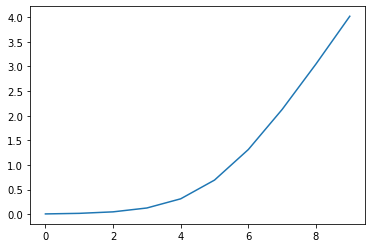

In [ ]:
plt.plot(F.softplus(torch.arange(-5,5).float()))

/home/johannes/anaconda3/envs/nbdev/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


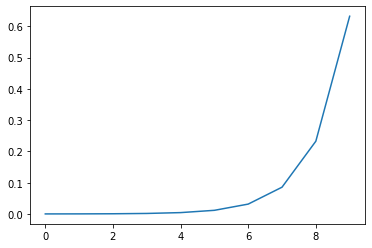

In [ ]:
plt.plot(F.softmax(torch.arange(-5,5).float()))

In [ ]:
y_lower, y_upper = preds[:, 0], preds[:, 0]+preds[:, 1]

In [ ]:
ksu = torch.sigmoid((y_upper*y_true)*s)

In [ ]:
khu = (torch.sign(y_upper*y_true) > 0).int()

In [ ]:
khu

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [ ]:
y_lower

tensor([-0.2150, -0.0373, -0.0664, -0.1514, -0.0763, -0.1669, -0.2402, -0.2522,
        -0.2219, -0.1682, -0.2088, -0.1296, -0.0894, -0.2470, -0.0757, -0.1998,
         0.0426, -0.2163, -0.0432, -0.1383, -0.2627, -0.1482, -0.2261, -0.1615,
        -0.1781, -0.1812, -0.1635, -0.3006, -0.1287, -0.3097, -0.1423, -0.0867,
        -0.3076, -0.2707, -0.1401, -0.1619, -0.1846, -0.1943, -0.3508, -0.2030,
        -0.0949, -0.2206, -0.1296, -0.0740, -0.1855, -0.0868, -0.0605, -0.1596,
        -0.1182, -0.1774, -0.1584, -0.0428, -0.1503, -0.3000, -0.2229, -0.0940,
        -0.1599,  0.0036, -0.1962, -0.1582, -0.1363, -0.1152, -0.1080, -0.0295,
        -0.1667, -0.1917, -0.1041, -0.0410, -0.0946, -0.0379, -0.1147, -0.1163,
        -0.2333, -0.3011, -0.2240, -0.0911, -0.1724, -0.1288, -0.1447, -0.1738,
        -0.1851, -0.1214, -0.1903, -0.1865, -0.1321, -0.2168, -0.1115, -0.1393,
        -0.1593, -0.1440, -0.1833, -0.1896, -0.0744, -0.1577, -0.0946, -0.2391,
        -0.2719,  0.0006, -0.1742, -0.19

In [ ]:
y_upper

tensor([1.0125, 0.9507, 1.1341, 1.2261, 0.9578, 1.2655, 1.0331, 1.3799, 1.1758,
        1.0343, 1.0520, 1.1780, 1.1278, 0.9600, 1.1459, 1.0721, 1.2432, 0.8925,
        1.3539, 1.2006, 1.2460, 1.3015, 1.1666, 1.1699, 1.3345, 1.0551, 1.3872,
        1.3417, 1.1222, 1.0703, 1.1570, 1.1313, 1.2327, 1.3396, 1.1941, 1.1885,
        1.3074, 1.0672, 1.0710, 1.2454, 1.4943, 1.1268, 1.2031, 1.4435, 1.1855,
        1.1028, 1.1619, 1.4476, 1.1487, 1.5705, 1.3223, 0.8941, 1.0758, 1.2868,
        1.3020, 1.2579, 1.2519, 1.1587, 1.1629, 1.0649, 1.1168, 1.2001, 1.0949,
        1.0564, 1.0763, 1.0126, 1.3438, 0.9129, 1.1583, 0.9154, 1.1087, 1.3220,
        1.2802, 1.0433, 1.3633, 1.2038, 1.0183, 1.3108, 1.1089, 1.2248, 1.2072,
        1.1324, 1.2276, 1.1366, 1.4469, 1.0298, 1.1344, 1.2845, 1.4002, 0.8993,
        1.0610, 1.3647, 1.1205, 1.1292, 1.1420, 1.0606, 1.0974, 0.9439, 1.1388,
        1.4899, 1.3278, 1.1295, 1.2323, 1.1965, 1.1490, 1.0899, 0.9409, 0.9582,
        1.1029, 1.0597, 1.1515, 1.0839, 

In [ ]:
torch.max(torch.zeros(1), picp_s)

tensor([0.3678])

In [ ]:
preds = torch.cat([y_lower[:,None], y_upper[:, None]], dim=1)

In [ ]:
preds.shape, y_results.shape

(torch.Size([10, 2]), torch.Size([10]))

In [ ]:
qd_loss(preds, y_results, alpha=0.4, l=0.2)

tensor(0.6159) tensor(0.3678)


tensor(1.0650)

In [ ]:
#export
class InceptionTimeBounds(nn.Module):
    '''
    use InceptionTimeVar implementation for bounds
    output[:, -1] is positive and y_upper corresponds to output[:,0]+output[:,1] --> loss
    '''
    
    def __init__(self, n_in, n_out, meanrange=None):
        super().__init__()
        models  = [InceptionTime(n_in, n_out+1)]
        if meanrange:
            self.sigmoid = Sigmoid(*meanrange)
        self.mod = nn.Sequential(*models)
        
    def forward(self, x):
        x = x.float()
        output = self.mod(x)
        ## enforce positivity of sigma^2
        ##output_sig_pos = tf.log(1 + tf.exp(output_sig)) + 1e-06
#         output[:,-1] = (output[:,-1].exp()+1).log_() + 1e-06
        output[:,-1] = F.softplus(output[:,-1])
        
        if getattr(self, 'sigmoid', None): output[:,:-1] = self.sigmoid(output[:,:-1])
        return output

In [ ]:
model = InceptionTimeBounds(10,1, meanrange=(-3,3))

In [ ]:
qd_loss(model(xb), y_true, add=True)

tensor(3760) tensor(3948.7781, grad_fn=<SumBackward0>)
tensor(0.5312, grad_fn=<DivBackward0>) tensor(0.2410, grad_fn=<MeanBackward0>)


tensor([0.8410], grad_fn=<AddBackward0>)